In [1]:
import os
import json
import csv
import configparser

import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors

from scipy.spatial.transform import Rotation

import traceback
import logging

logger = logging.getLogger('arc.'+__name__)

# Environment

In [2]:
def list_dirs(data_path):
    items = [ (f.path, f.name) for f in os.scandir(data_path) if f.is_dir()]
    for dirname, name in items:
        logger.info(dirname)
    return items

In [50]:
data_dir  = 'data'
tasks = {}
paths = {}

data_path = Path( data_dir + '/core_knowledge/')
# task_dir  = 'circleapixelone'
# filename  = 'circleapixelone_tasks.npz' 
task_dir  = 'moveapixelxone-5x5'
skills    = ['move lone pixel by one']
filename  = 'moveapixelxone-5x5_tasks.npz' 

dirs = list_dirs(data_path)

for path, name in dirs:
    paths[name]   = path
    tasks[name]   = sorted(os.listdir(paths[name]))

print(dirs)
for v in tasks:
    print(v, len(tasks[v]))

[('data/core_knowledge/moveapixelxone', 'moveapixelxone'), ('data/core_knowledge/moveapixelxone-5x5', 'moveapixelxone-5x5'), ('data/core_knowledge/circleapixel', 'circleapixel'), ('data/core_knowledge/circleapixelone', 'circleapixelone')]
moveapixelxone 1000
moveapixelxone-5x5 50
circleapixel 1000
circleapixelone 1000


In [51]:
def skill_series(task_name):
    return skills

In [12]:
def get_one(bucket, file):
    """
    Retrieve the details of one task. Provide details like training/evaluation/test, choose to id by index/filename.
    """
    i = tasks[bucket].index(file) # This will fail is file is not in the list
    task_file = str(paths[bucket]) + "/" + str(tasks[bucket][i])
    with open(task_file, 'r') as f:
        task = json.load(f)
    return os.path.splitext(tasks[bucket][i])[0], task_file, task

# Task Metadata

In [13]:
def create_df(folder_path):
    task_names_list = sorted(os.listdir(folder_path))
    task_list = []
    for task_name in task_names_list: 
        task_file = str(folder_path / task_name)
        with open(task_file, 'r') as f:
            # print(f)
            task = json.load(f)
            task_list.append(task)
    
    df = pd.DataFrame()
    df['task_name'] = task_names_list
    df['task'] = task_list
    df['number_of_train_pairs'] = df['task'].apply(lambda x: len(x['train']))
    df['number_of_test_pairs'] = df['task'].apply(lambda x: len(x['test']))
    
    # Compare image sizes
    df['inputs_all_have_same_height'] = df['task'].apply(
        lambda task: int(len(set([len(example['input']) for example in task['train']+task.get('test')])) == 1)
    )
    df['inputs_all_have_same_width'] = df['task'].apply(
        lambda task: int(len(set([len(example['input'][0]) for example in task['train']+task.get('test')])) == 1)
    )
    df['inputs_all_have_same_shape'] = df['inputs_all_have_same_height'] * df['inputs_all_have_same_width']
    df['input_height_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['input'])
                     if (len(set([len(example['input']) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )
    df['input_width_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['input'][0])
                     if (len(set([len(example['input'][0]) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )
    
    df['outputs_all_have_same_height'] = df['task'].apply(
        lambda task: int(len(set([len(example['output']) for example in task['train']+task.get('test')])) == 1)
    )
    df['outputs_all_have_same_width'] = df['task'].apply(
        lambda task: int(len(set([len(example['output'][0]) for example in task['train']+task.get('test')])) == 1)
    )
    df['outputs_all_have_same_shape'] = df['outputs_all_have_same_height'] * df['outputs_all_have_same_width']
    df['output_height_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'])
                     if (len(set([len(example['output']) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )
    df['output_width_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'][0])
                     if (len(set([len(example['output'][0]) for example in task['train']+task.get('test')])) == 1)
                     else np.nan
    )    
    
    df['in_each_pair_shape_doesnt_change'] = df['task'].apply(
        lambda task: np.prod([int(len(example['input'][0])==len(example['output'][0])
                                  and len(example['input'])==len(example['output'])
                                 ) for example in task['train']+task.get('test')
                            ])
    )
    df['in_each_pair_shape_ratio_is_the_same'] = df['task'].apply(
        lambda task: (len(set([len(example['input'][0]) / len(example['output'][0])
                                 for example in task['train']+task.get('test')]))==1) * (
                      len(set([len(example['input']) / len(example['output'])
                                 for example in task['train']+task.get('test')]))==1)
    )
    df['o/i_height_ratio_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output']) / len(task['train'][0]['input'])
                     if (len(set([len(example['input']) / len(example['output'])
                                 for example in task['train']+task.get('test')]))==1)
                     else np.nan
    )
    df['o/i_width_ratio_if_constant'] = df['task'].apply(
        lambda task: len(task['train'][0]['output'][0]) / len(task['train'][0]['input'][0])
                     if (len(set([len(example['input'][0]) / len(example['output'][0])
                                 for example in task['train']+task.get('test')]))==1)
                     else np.nan
    )
    
    return df

In [14]:
training_path = data_path / task_dir
training_descriptive_df = create_df(training_path)
training_descriptive_df.head()

,task_name,task,number_of_train_pairs,number_of_test_pairs,inputs_all_have_same_height,inputs_all_have_same_width,inputs_all_have_same_shape,input_height_if_constant,input_width_if_constant,outputs_all_have_same_height,outputs_all_have_same_width,outputs_all_have_same_shape,output_height_if_constant,output_width_if_constant,in_each_pair_shape_doesnt_change,in_each_pair_shape_ratio_is_the_same,o/i_height_ratio_if_constant,o/i_width_ratio_if_constant
0,moveapixelxone-5x5-0228da178e.json,"{'train': [{'input': [[2, 2, 2, 2, 2], [2, 2, ...",3,1,1,1,1,5,5,1,1,1,5,5,1,1,1.0,1.0
1,moveapixelxone-5x5-04709d81d0.json,"{'train': [{'input': [[2, 2, 2, 2, 2], [2, 2, ...",3,1,1,1,1,5,5,1,1,1,5,5,1,1,1.0,1.0
2,moveapixelxone-5x5-0fdb1b6fc4.json,"{'train': [{'input': [[2, 2, 2, 2, 2], [2, 2, ...",3,1,1,1,1,5,5,1,1,1,5,5,1,1,1.0,1.0
3,moveapixelxone-5x5-100e3f2242.json,"{'train': [{'input': [[2, 2, 2, 2, 2], [2, 2, ...",3,1,1,1,1,5,5,1,1,1,5,5,1,1,1.0,1.0
4,moveapixelxone-5x5-10c47e4c10.json,"{'train': [{'input': [[2, 2, 2, 2, 2], [2, 8, ...",3,1,1,1,1,5,5,1,1,1,5,5,1,1,1.0,1.0


In [17]:
# training_descriptive_df[training_descriptive_df['task_name'] == 'circleapixelone-00aed4d843.json']
training_descriptive_df[training_descriptive_df['task_name'] == 'moveapixelxone-5x5-3b6ec14321.json'] 
# ['number_of_train_pairs']
# input_height_if_constant	input_width_if_constant	
# output_height_if_constant	output_width_if_constant


,task_name,task,number_of_train_pairs,number_of_test_pairs,inputs_all_have_same_height,inputs_all_have_same_width,inputs_all_have_same_shape,input_height_if_constant,input_width_if_constant,outputs_all_have_same_height,outputs_all_have_same_width,outputs_all_have_same_shape,output_height_if_constant,output_width_if_constant,in_each_pair_shape_doesnt_change,in_each_pair_shape_ratio_is_the_same,o/i_height_ratio_if_constant,o/i_width_ratio_if_constant
13,moveapixelxone-5x5-3b6ec14321.json,"{'train': [{'input': [[2, 2, 2, 2, 2], [2, 8, ...",5,1,1,1,1,5,5,1,1,1,5,5,1,1,1.0,1.0


# Data Processing Utiities

In [21]:
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
cmap = colors.ListedColormap(rgbs)
norm = colors.Normalize(vmin=0, vmax=9)

## RGB and Gray

In [22]:
def rgb_to_gray(R, G, B):
    grayscale = 0.3 * R + 0.59 * G + 0.11 * B
    return grayscale

def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

## Test Distances of RGB Encoding

In [23]:
vecs = np.zeros((10, 3))

for i, cstr in enumerate(rgbs):
    vecs[i] = to_rgb(cstr)
    print(cstr, vecs[i])

dists=[]
for i, x in enumerate(vecs):
    for j, y in enumerate(vecs):
        if i != j:
            dist = np.linalg.norm(x - y)
            # print (str(i) + " vs " + str(j) + " " + str(dist))
            dists.append(dist)

print("Distance Max {} Min {}".format(np.max(dists), np.min(dists)))

#000000 [0. 0. 0.]
#0074D9 [0.         0.45490196 0.85098039]
#FF4136 [1.         0.25490196 0.21176471]
#2ECC40 [0.18039216 0.8        0.25098039]
#FFDC00 [1.        0.8627451 0.       ]
#AAAAAA [0.66666667 0.66666667 0.66666667]
#F012BE [0.94117647 0.07058824 0.74509804]
#FF851B [1.         0.52156863 0.10588235]
#7FDBFF [0.49803922 0.85882353 1.        ]
#870C25 [0.52941176 0.04705882 0.14509804]
Distance Max 1.4091206176309676 Min 0.2869184270406329


## Test Distances of GSB Encodeing

In [24]:
# https://polytope.miraheze.org/wiki/Gyroelongated_square_bipyramid 

# A gyroelongated square bipyramid of edge length 1 has the following vertices:
# (0,          0, ±{2*sqrt(2) + sqrt[4](8)} / 4),
# (±1/2,    ±1/2,     sqrt[4](8) / 4),
# (0, ±sqrt(2)/2, -sqrt[4](8) / 4),
# (±sqrt(2)/2, 0, -sqrt[4](8) / 4).

qurt_8 = np.power(8,1/4)
sqrt_2 = np.power(2,1/2)

coords = [None]*11
coords[0] = [0,          0, +(2*sqrt_2 + qurt_8) / 4]
coords[1] = [0,          0, -(2*sqrt_2 + qurt_8) / 4]
coords[2] = [+0.5,    +0.5,     qurt_8 / 4]
coords[3] = [-0.5,    +0.5,     qurt_8 / 4]
coords[4] = [+0.5,    -0.5,     qurt_8 / 4]
coords[5] = [-0.5,    -0.5,     qurt_8 / 4]
coords[6] = [0, +sqrt_2/2, -qurt_8 / 4]
coords[7] = [0, -sqrt_2/2, -qurt_8 / 4]
coords[8] = [+sqrt_2/2, 0, -qurt_8 / 4]
coords[9] = [-sqrt_2/2, 0, -qurt_8 / 4]
coords[10] = [0,        0,           0]

coords = np.array(coords)
print(coords)

# Testing distances
dists=[]
for i, x in enumerate(coords):
    for j, y in enumerate(coords):
        if i != j:
            dist = np.linalg.norm(x - y)
            # print (str(i) + " vs " + str(j) + " " + str(dist))
            dists.append(dist)
            
print("Distance Max {} Min {}".format(np.max(dists), np.min(dists)))

[[ 0.          0.          1.12755499]
 [ 0.          0.         -1.12755499]
 [ 0.5         0.5         0.42044821]
 [-0.5         0.5         0.42044821]
 [ 0.5        -0.5         0.42044821]
 [-0.5        -0.5         0.42044821]
 [ 0.          0.70710678 -0.42044821]
 [ 0.         -0.70710678 -0.42044821]
 [ 0.70710678  0.         -0.42044821]
 [-0.70710678  0.         -0.42044821]
 [ 0.          0.          0.        ]]
Distance Max 2.2551099776268098 Min 0.8226643880080363


## Test Distances of Rotated GSB Encoding

In [25]:
r=Rotation.from_euler('xyz',[45,45,45],degrees=True)
print(r.as_matrix())
coords = r.apply(coords)
print(coords)

# Testing distances
# Still 2.2551099776268098 0.8226643880080363 after rotation.
dists=[]
for i, x in enumerate(coords):
    for j, y in enumerate(coords):
        if i != j:
            dist = np.linalg.norm(x - y)
            # print (str(i) + " vs " + str(j) + " " + str(dist))
            dists.append(dist)
            
print("Distance Max {} Min {}".format(np.max(dists), np.min(dists)))

[[ 0.5        -0.14644661  0.85355339]
 [ 0.5         0.85355339 -0.14644661]
 [-0.70710678  0.5         0.5       ]]
[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]
Distance Max 2.2551099776268098 Min 0.8226643880080363


## Converstion Functions

In [26]:
gsb_grid_mask = np.tile(coords,(32,32,1,1))
print(gsb_grid_mask.shape)
print(gsb_grid_mask[0,0,1,2])

(32, 32, 11, 3)
-0.5637774944067024


In [27]:
def convert_grid_to_gsb(grid):
    new_grid = np.zeros((32,32,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = coords[cell]
    return new_grid        

def convert_grid_to_rgb(grid):
    new_grid = np.zeros((32,32,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            # color = rgbs[cell]
            # R = int(color[1:3],16) / 255
            # G = int(color[3:5],16) / 255
            # B = int(color[5:7],16) / 255
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid        

def convert_grid_to_channels(grid):
    new_grid = np.zeros((32,32,10))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c][cell] = 1
    return new_grid

def convert_grid_to_fractions(grid):
    frac_grid = grid / 10
    new_grid = np.zeros((32,32))
    for r, row in enumerate(frac_grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = cell if cell > 0 else 1.0
    # print(grid)
    # print(new_grid)
    return new_grid        

def convert_grid_to_gray(grid):
    new_grid = np.zeros((32,32))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            color = rgbs[cell]
            R = int(color[1:3],16)
            G = int(color[3:5],16)
            B = int(color[5:7],16)
            # print(cell, R, G, B, rgb_to_gray(R, G, B))
            # print(r, c)
            new_grid[r][c] = rgb_to_gray(R, G, B)
    # print(grid)
    # print(new_grid)
    return new_grid

In [52]:
convert_grid = convert_grid_to_gsb     

def repackage(task_id, task, task_type):
    
    grids  = []
    labels = []
    attrs  = []
    
    ta = task[task_type]

    label = task_id + '_' + task_type
    skill = skill_series(task_id + ".json")
    for i in range(len(ta)):

        # Metadata
        labels.append(label + '_' + str(i))   
        i_problem = np.array(ta[i]['input'])
        o_problem = np.array(ta[i]['output'])
        attr  = { 'skill': skill, 'i_shape': i_problem.shape, 'o_shape': o_problem.shape }
        attrs.append(attr)

        # Convert inputs and outputs
        i_problem = convert_grid(i_problem)        
        o_problem = convert_grid(o_problem)                

        # Add to the list
        grids.append((i_problem, o_problem)) # Tuple

    return grids, labels, attrs

#####
# Each row is a task of ((encnoder input - 2 grids), (decoder input/output - 2 grids)). 
#
# @param task_id
# @param task - the task file containing x example pairs and 1/2 test pairs.
# @param train_set
# @param test_set
#
# Here is the formulation:
# For each in 'train', assign as decoder input, then we pair with others in the set, including itself.
# For each in 'test', assign as decoder input, we pair only with those in the 'train'. 
# A test task is never to be included in the training set. Put into test set.
#
def convert_task(task_id, task, train_set, test_set):

    task_type=['train','test']
    # problem_pairs=[None] * 2
    num_tests   = len(task['test'])
    num_trains  = len(task['train'])

    # The source task is of the form { 'train': [ { 'input': [], 'output': [] }, ... ], 'test': [] }
    # flatten them and convert any data representation
    train_grids, train_labels, train_attrs = repackage(task_id, task, 'train')
    test_grids,  test_labels,  test_attrs  = repackage(task_id, task, 'test')

    # Formulate the encoder/decoder model training data, add to train_set
    # The training pairs are remixed to form a set of encoder/decoder training groundtruth.
    # For example, pair 1 as encoder feature, and pair 2 as decoder feature.
    # We will reserve the first problem to be associated with test as encoder feature.
    for j, d in enumerate(train_grids[1:], start=1):
        for i, e in enumerate(train_grids[1:], start=1):
            train_set['gtrain'].append((train_grids[i], train_grids[j])) # Tuple
            train_set['ltrain'].append(train_labels[i] + "|" + train_labels[j])
            train_set['atrain'].append({ 'encoder' : train_attrs[i], 'decoder' :  train_attrs[j] })

    # Formulate the model testing data, add to test_set
    # Use the first training pair as encoder feature. The test as decoder feature.
    # Since the tasks were generated with mutually exclusive training grids and testing grids,
    # the decoder portion of test_set is therefore fresh and never been seen in training. 
    # The encoder portion of test_set may still have been seen in training set,
    # as there could be pairs from other tasks matching this the first training pair.
    for j, d in enumerate(test_grids):
        test_set['gtest'].append((train_grids[0], test_grids[j])) # Tuple
        test_set['ltest'].append(train_labels[0] + "|" + test_labels[j])
        test_set['atest'].append({ 'encoder' : train_attrs[0], 'decoder' :  test_attrs[j] })                
    
    return train_set, test_set

def conversion(bucket, level=logging.CRITICAL):
    start = datetime.now()
    count = 0

    train_set = {'gtrain': [], 'ltrain': [], 'atrain': []}
    test_set  = {'gtest' : [], 'ltest' : [], 'atest' : []}
    
    for t in tasks[bucket]: # a list of task filenames
        # load task
        task_id, task_file, task = get_one(bucket, t)
        # process 
        convert_task(task_id, task, train_set, test_set)
        # Count
        count+=1
        if count % 20 == 0:
            print("processed " + str(count))
        # break

    end   = datetime.now()
    print("Exec time: %s" % str(end-start))    

    return train_set, test_set

# Processing and Packaging

In [53]:
# g = grids; l = labels; a = attributes
# l - the label provenance of the data to the original task inputs/outputs
# a - any attribute metadata; skill tags, i/o grid dimension... etc mostly unused.
combined_train_set = {'gtrain':[], 'ltrain':[], 'atrain':[] }
combined_test_set  = {'gtest':[],  'ltest':[],  'atest':[]  }

def absorb(train_set, test_set):
    facets = ['gtrain', 'ltrain', 'atrain']
    for i in range(len(train_set['gtrain'])):
        for f in facets:
            combined_train_set[f].append(train_set[f][i])
    facets = ['gtest',  'ltest',  'atest']        
    for i in range(len(test_set['gtest'])):
        for f in facets:
            combined_test_set[f].append(test_set[f][i])

print(tasks.keys(),task_dir)
train_set, test_set = conversion(task_dir)
absorb(train_set, test_set)
print(len(combined_train_set['gtrain']), len(combined_test_set['gtest']))
print(filename)

dict_keys(['moveapixelxone', 'moveapixelxone-5x5', 'circleapixel', 'circleapixelone']) moveapixelxone-5x5
processed 20
processed 40
Exec time: 0:00:00.037931
224 51
moveapixelxone-5x5_tasks.npz


In [54]:
np.savez_compressed(data_dir + '/' + filename, 
                    x_train=combined_train_set['gtrain'],  x_test=combined_test_set['gtest'], 
                    y_train=combined_train_set['ltrain'],  y_test=combined_test_set['ltest'], 
                    a_train=combined_train_set['atrain'],  a_test=combined_test_set['atest'])
print("Saved")

Saved


# Plot Utilities

In [41]:
def plot_grid(grid, label):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444'])
    norm = colors.Normalize(vmin=0, vmax=10)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(grid,cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()  

def plot_gray_grid(grid, label):

    fig, axs = plt.subplots(1, 1, figsize=(30,30))
    axs.imshow(grid,cmap='gray', vmin=0, vmax=255)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()


def plot_frac_grid(frac_grid, label):
    grid = np.around(frac_grid*10)
    self.plot_grid(grid, label)      

def plot_channel_grid(channel_grid, label):
    grid = np.zeros((32,32))
    for i in range(10):
        for r, row in enumerate(grid):
            for c, cell in enumerate(row):
                if channel_grid[r][c][i]:
                    grid[r][c]=i

    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(grid,cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()

def plot_rgb_grid(rgb_grid, label):
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(rgb_grid)
    axs.axis('off')
    axs.set_title(label)
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()   
    plt.show()      

# Sanity Checks

In [42]:
# Rotated GSB 
print(coords)

[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]


moveapixelxone-5x5-3b6ec14321_train_0|moveapixelxone-5x5-3b6ec14321_test_0
[[ 2  2  2 ... 10 10 10]
 [ 2  2  2 ... 10 10 10]
 [ 2  2  2 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


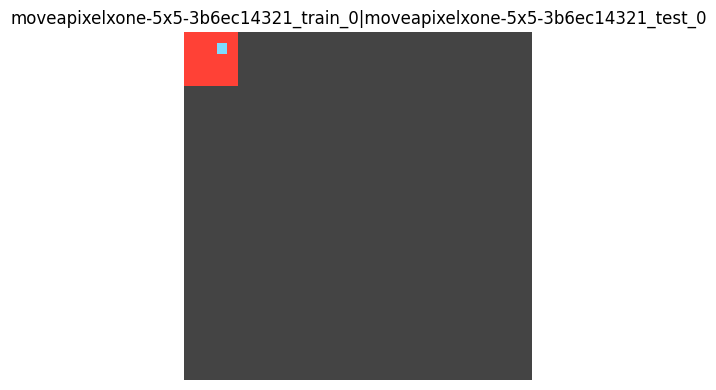

In [43]:
idx = next(i for i, s in enumerate(combined_test_set['ltest']) if s.endswith('moveapixelxone-5x5-3b6ec14321_test_0'))
print(combined_test_set['ltest'][idx])
gsb_grid_mask = np.tile(coords,(32,32,1,1))
g = combined_test_set['gtest'][idx][1][1].copy() # [encoder/decoder][start/end]
g = np.expand_dims(g, 2)
dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
recovered = np.argmin(dist, axis=2)
print(recovered)
plot_grid(recovered, combined_test_set['ltest'][idx])

moveapixelxone-5x5-3b6ec14321_train_1|moveapixelxone-5x5-3b6ec14321_train_1
[[ 2  2  2 ... 10 10 10]
 [ 2  2  2 ... 10 10 10]
 [ 2  2  2 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


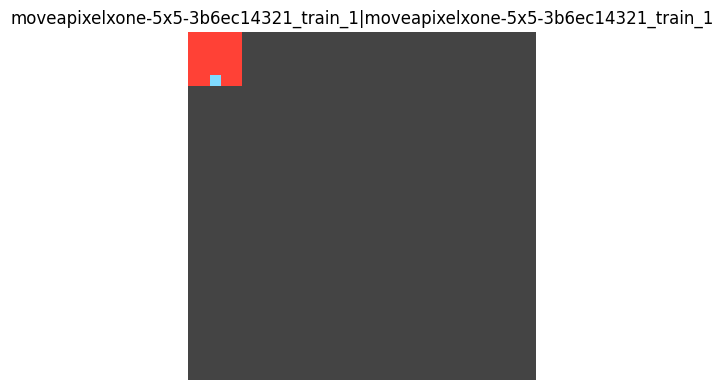

In [44]:
idx = next(i for i, s in enumerate(combined_train_set['ltrain']) if s.startswith('moveapixelxone-5x5-3b6ec14321'))
print(combined_train_set['ltrain'][idx])
gsb_grid_mask = np.tile(coords,(32,32,1,1))
g = combined_train_set['gtrain'][idx][0][0].copy()
g = np.expand_dims(g, 2)
dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
recovered = np.argmin(dist, axis=2)
print(recovered)
plot_grid(recovered, combined_train_set['ltrain'][idx])